# Trading System Analysis with Stacking Ensemble (Top 3 SHAP Features)
This notebook simulates a trading system using the stacking ensemble model trained on the top 3 SHAP features. It plots cumulative results for train and test sets, applies transaction costs, and analyzes performance by probability bins.

In [1]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import json
import os

In [2]:
# 2. Load Data and Results from Notebook 6
features_path = '../data/processed/BRL_X_features.csv'
df = pd.read_csv(features_path, index_col=0)
df = df.dropna()  # Drop rows with any NaN values
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Load SHAP selected features from notebook 6
shap_features_path = os.path.abspath(os.path.join('..', 'data', 'processed', 'metrics', 'shap_selected_features.txt'))
with open(shap_features_path, 'r') as f:
    selected_features = [line.strip() for line in f if line.strip()]

# Load SHAP results for additional context
shap_results_path = os.path.abspath(os.path.join('..', 'data', 'processed', 'metrics', 'shap_results.json'))
with open(shap_results_path, 'r') as f:
    shap_results = json.load(f)

# Load best stacking ensemble parameters from notebook 5
best_params_path = os.path.abspath(os.path.join('..', 'data', 'processed', 'metrics', 'best_params_stacking.json'))
with open(best_params_path, 'r') as f:
    best_params = json.load(f)

print(f"Loaded {len(selected_features)} SHAP-selected features: {selected_features}")
print(f"SHAP accuracy with selected features: {shap_results['accuracy_selected_features']:.4f}")
print(f"Base learners: {best_params['base_learners']}")
print(f"Meta learner: {best_params['meta_learner']}")

Loaded 13 SHAP-selected features: ['a', 'v', 'cat', 'g', 'm', 'k', 'mm_std6', 'std12', 'M', 'mm_std12', 'std6', 'w', 'f']
SHAP accuracy with selected features: 0.5469
Base learners: ['QuadraticDiscriminantAnalysis', 'LinearDiscriminantAnalysis', 'LinearSVC']
Meta learner: LogisticRegression


In [3]:
# 3. Build Optimized Stacking Ensemble with Selected Features
# Prepare feature subsets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Import additional model classes needed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

# Build base learners with optimized hyperparameters from notebook 5
base_learners = []
for i, config in enumerate(best_params['base_learners_config'], 1):
    model_name = config['name']
    params = config['parameters']
    
    if model_name == 'QuadraticDiscriminantAnalysis':
        model = QuadraticDiscriminantAnalysis(**params)
    elif model_name == 'LinearDiscriminantAnalysis':
        model = LinearDiscriminantAnalysis(**params)
    elif model_name == 'LinearSVC':
        model = LinearSVC(**params, random_state=42)
    
    base_learners.append((f'model_{i}', model))

# Build meta-learner with optimized hyperparameters
meta_config = best_params['meta_learner_config']
meta_params = meta_config['parameters']
if meta_config['name'] == 'LogisticRegression':
    meta_learner = LogisticRegression(**meta_params, random_state=42, max_iter=1000)

# Create and train the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

print("Training stacking ensemble with SHAP-selected features...")
stacking_ensemble.fit(X_train_selected, y_train)

# Generate predictions and probabilities
y_pred_train = stacking_ensemble.predict(X_train_selected)
y_pred_test = stacking_ensemble.predict(X_test_selected)
y_proba_train = stacking_ensemble.predict_proba(X_train_selected)[:, 1]
y_proba_test = stacking_ensemble.predict_proba(X_test_selected)[:, 1]

print(f"Training complete. Model ready for trading system analysis.")

Training stacking ensemble with SHAP-selected features...
Training complete. Model ready for trading system analysis.
Training complete. Model ready for trading system analysis.


In [4]:
# 4. Calculate Trading System Results (Train and Test)
def trading_results(y_true, y_pred, cost=0.00025):
    # +1 if prediction matches actual, -1 otherwise, minus transaction cost
    result = np.where(y_pred == y_true, 1 - cost, -1 - cost)
    return result

train_results = trading_results(y_train.values, y_pred_train)
test_results = trading_results(y_test.values, y_pred_test)

Date range: 2010-01-21 00:00:00 to 2025-10-24 00:00:00
Train dates: 2010-01-21 00:00:00 to 2022-08-29 00:00:00
Test dates: 2022-08-30 00:00:00 to 2025-10-24 00:00:00


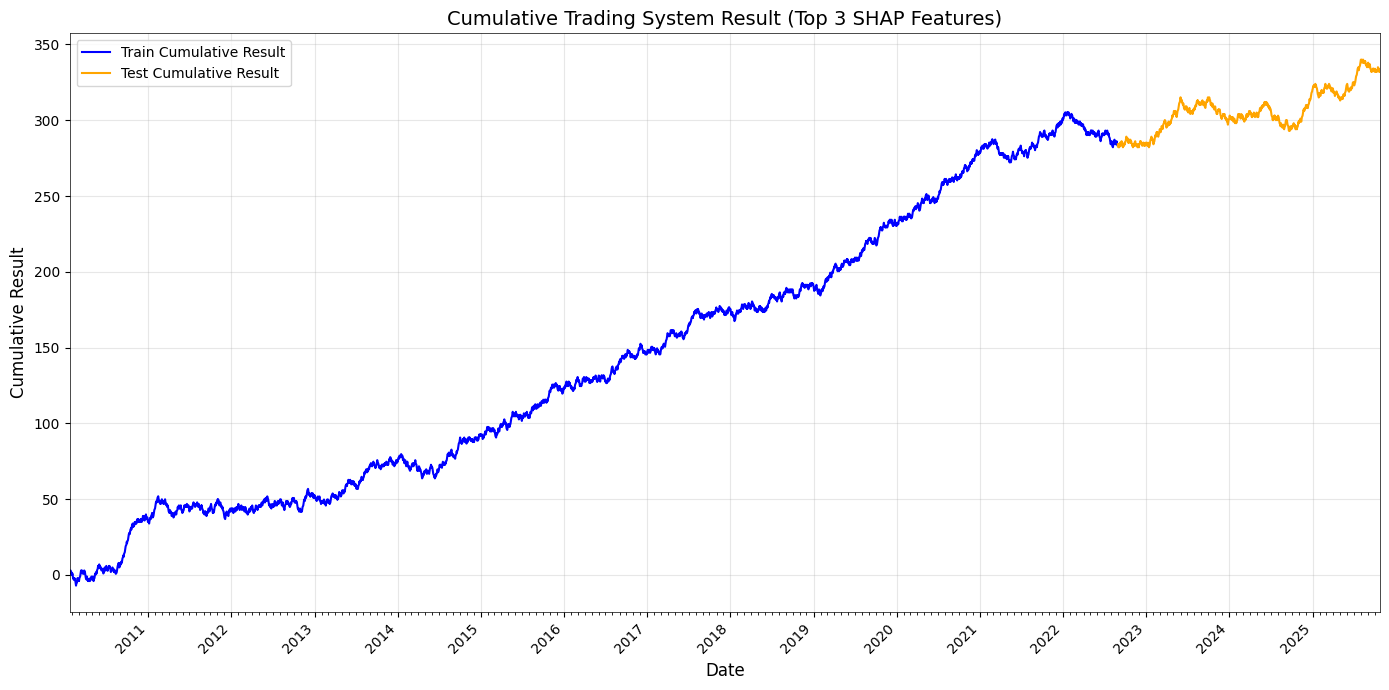

In [5]:
# 5. Plot Cumulative Trading Results Curve (Train vs Test) with Sequential Dates and White Background
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data - ensure dates are parsed correctly
all_dates = pd.to_datetime(df.index)
train_len = len(train_results)
test_len = len(test_results)
cum_train = np.cumsum(train_results)
cum_test = np.cumsum(test_results)

# Debug: Check date range
print(f"Date range: {all_dates[0]} to {all_dates[-1]}")
print(f"Train dates: {all_dates[0]} to {all_dates[train_len-1]}")
print(f"Test dates: {all_dates[train_len]} to {all_dates[train_len+test_len-1]}")

# Create figure with explicit white background
plt.style.use('default')  # Reset to default style
fig = plt.figure(figsize=(14,7), facecolor='white')
ax = fig.add_subplot(111, facecolor='white')

# Plot train results
ax.plot(all_dates[:train_len], cum_train, color='blue', label='Train Cumulative Result', linewidth=1.5)

# Plot test results starting from where train ends (continuing cumulative)
ax.plot(all_dates[train_len:train_len+test_len], cum_test + cum_train[-1], color='orange', label='Test Cumulative Result', linewidth=1.5)

# Configure axes
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Result', fontsize=12)
ax.set_title('Cumulative Trading System Result (Top 3 SHAP Features)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Format dates on x-axis - show years from 2010 onwards
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set x-axis limits to actual data range
ax.set_xlim(all_dates[0], all_dates[train_len+test_len-1])

# Ensure clean appearance
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

Test set cumulative result by probability bin (10 bins):
Bin  1 (0.4453 - 0.4890): Cumulative=  28.98, Count=  83, Avg= 0.3491
Bin  2 (0.4890 - 0.4965): Cumulative=   7.98, Count=  82, Avg= 0.0973
Bin  3 (0.4965 - 0.5013): Cumulative=   5.98, Count=  82, Avg= 0.0729
Bin  4 (0.5013 - 0.5065): Cumulative=  -4.02, Count=  82, Avg=-0.0490
Bin  5 (0.5065 - 0.5110): Cumulative=   3.98, Count=  82, Avg= 0.0485
Bin  6 (0.5110 - 0.5148): Cumulative= -24.02, Count=  82, Avg=-0.2929
Bin  7 (0.5148 - 0.5194): Cumulative=  17.98, Count=  82, Avg= 0.2193
Bin  8 (0.5194 - 0.5239): Cumulative=  -8.02, Count=  82, Avg=-0.0978
Bin  9 (0.5239 - 0.5307): Cumulative=  11.98, Count=  82, Avg= 0.1461
Bin 10 (0.5307 - 0.5895): Cumulative=   7.98, Count=  82, Avg= 0.0973

Bins around 0.50 probability (low confidence) - consider NOT trading:
  Bin  1 (0.4453 - 0.4890): Avg Result= 0.3491
  Bin  2 (0.4890 - 0.4965): Avg Result= 0.0973
  Bin  3 (0.4965 - 0.5013): Avg Result= 0.0729
  Bin  4 (0.5013 - 0.5065): Avg

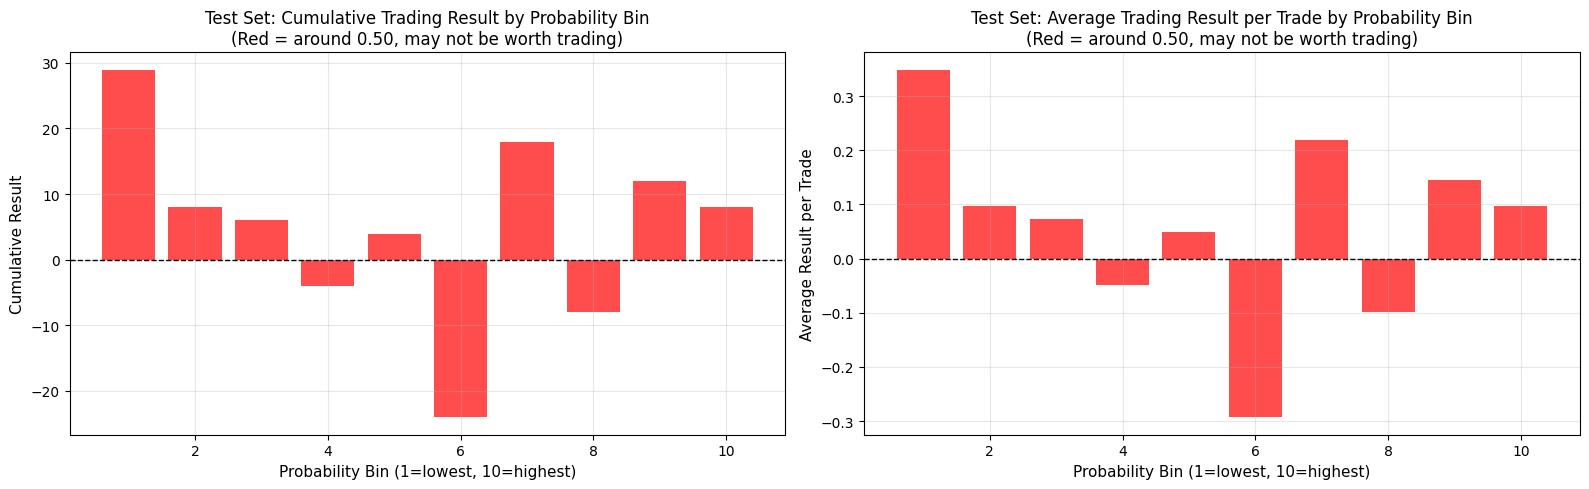

In [6]:
# 6. Bin Prediction Probabilities with qcut (Test Set) - 10 bins to identify optimal trading ranges
if y_proba_test is not None:
    # Use 10 bins (deciles) to identify ranges around 0.50 where not trading might be optimal
    test_bins, bin_edges = pd.qcut(y_proba_test, q=10, retbins=True, labels=False, duplicates='drop')
    test_bin_results = []
    test_bin_counts = []
    for b in range(len(bin_edges)-1):
        bin_mask = (test_bins == b)
        bin_cum_result = np.cumsum(test_results[bin_mask])[-1] if np.any(bin_mask) else 0
        bin_count = np.sum(bin_mask)
        test_bin_results.append(bin_cum_result)
        test_bin_counts.append(bin_count)
    
    print("Test set cumulative result by probability bin (10 bins):")
    print("="*80)
    for b, res in enumerate(test_bin_results):
        avg_result = res / test_bin_counts[b] if test_bin_counts[b] > 0 else 0
        print(f"Bin {b+1:2d} ({bin_edges[b]:.4f} - {bin_edges[b+1]:.4f}): Cumulative={res:7.2f}, Count={test_bin_counts[b]:4d}, Avg={avg_result:7.4f}")
    
    # Highlight bins around 0.50 probability
    print("\n" + "="*80)
    print("Bins around 0.50 probability (low confidence) - consider NOT trading:")
    for b in range(len(bin_edges)-1):
        if 0.45 <= bin_edges[b] <= 0.55 or 0.45 <= bin_edges[b+1] <= 0.55:
            avg_result = test_bin_results[b] / test_bin_counts[b] if test_bin_counts[b] > 0 else 0
            print(f"  Bin {b+1:2d} ({bin_edges[b]:.4f} - {bin_edges[b+1]:.4f}): Avg Result={avg_result:7.4f}")
    
    # Plot cumulative result per bin
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
    # Bar plot of cumulative results
    colors = ['red' if 0.45 <= bin_edges[i] <= 0.55 or 0.45 <= bin_edges[i+1] <= 0.55 else 'green' for i in range(len(test_bin_results))]
    ax1.bar(range(1, len(test_bin_results)+1), test_bin_results, color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Probability Bin (1=lowest, 10=highest)', fontsize=11)
    ax1.set_ylabel('Cumulative Result', fontsize=11)
    ax1.set_title('Test Set: Cumulative Trading Result by Probability Bin\n(Red = around 0.50, may not be worth trading)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Average result per bin
    avg_results = [test_bin_results[i] / test_bin_counts[i] if test_bin_counts[i] > 0 else 0 for i in range(len(test_bin_results))]
    ax2.bar(range(1, len(avg_results)+1), avg_results, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Probability Bin (1=lowest, 10=highest)', fontsize=11)
    ax2.set_ylabel('Average Result per Trade', fontsize=11)
    ax2.set_title('Test Set: Average Trading Result per Trade by Probability Bin\n(Red = around 0.50, may not be worth trading)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

STRATEGY COMPARISON (Test Set)

Strategy 1: Trade Everything
  Total Trades: 821
  Cumulative Result: 48.79
  Average per Trade: 0.0594

Strategy 2: Exclude Bins 4-6 (probabilities 0.5013 to 0.5148)
  Total Trades: 575
  Trades Removed: 246
  Cumulative Result: 72.86
  Average per Trade: 0.1267
  Improvement: 24.06 (49.3%)


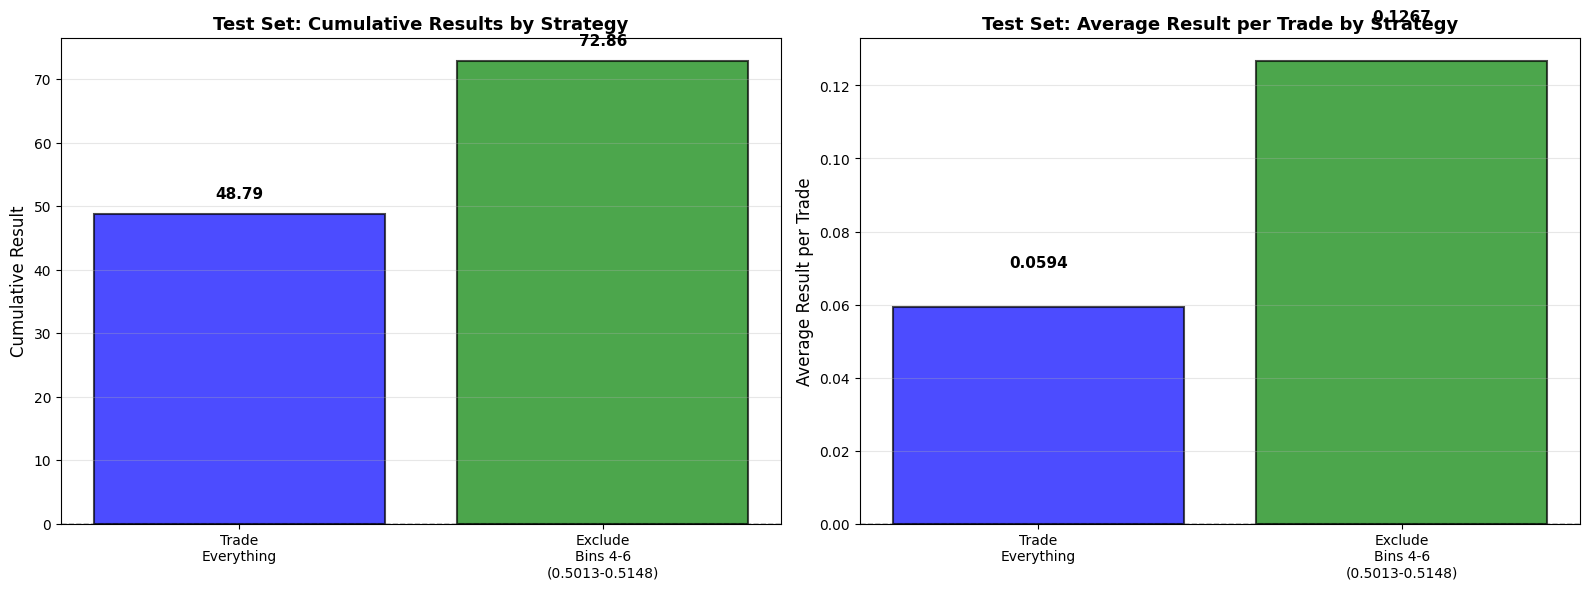


REMOVED TRADES ANALYSIS
Probability range removed: 0.50 to 0.5487
Number of trades removed: 246
Cumulative result of removed trades: -24.06
Average result of removed trades: -0.0978


In [8]:
# 7. Compare Trading Strategies: Full vs Filtered (Exclude Bins 4-6: 0.5013-0.5148)
if y_proba_test is not None:
    # Strategy 1: Trade everything (baseline)
    strategy1_results = test_results.copy()
    strategy1_cumulative = np.sum(strategy1_results)
    strategy1_count = len(strategy1_results)
    
    # Strategy 2: Exclude probability range 0.5013 to 0.5148 (bins 4-6: uncertainty zone near 0.5)
    mask_strategy2 = (y_proba_test < 0.5013) | (y_proba_test > 0.5148)
    strategy2_results = test_results[mask_strategy2]
    strategy2_cumulative = np.sum(strategy2_results)
    strategy2_count = len(strategy2_results)
    
    # Print comparison
    print("="*80)
    print("STRATEGY COMPARISON (Test Set)")
    print("="*80)
    print(f"\nStrategy 1: Trade Everything")
    print(f"  Total Trades: {strategy1_count}")
    print(f"  Cumulative Result: {strategy1_cumulative:.2f}")
    print(f"  Average per Trade: {strategy1_cumulative/strategy1_count:.4f}")
    
    print(f"\nStrategy 2: Exclude Bins 4-6 (probabilities 0.5013 to 0.5148)")
    print(f"  Total Trades: {strategy2_count}")
    print(f"  Trades Removed: {strategy1_count - strategy2_count}")
    print(f"  Cumulative Result: {strategy2_cumulative:.2f}")
    print(f"  Average per Trade: {strategy2_cumulative/strategy2_count:.4f}")
    print(f"  Improvement: {strategy2_cumulative - strategy1_cumulative:.2f} ({((strategy2_cumulative - strategy1_cumulative)/abs(strategy1_cumulative)*100):.1f}%)")
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    
    # Cumulative results comparison
    strategies = ['Trade\nEverything', 'Exclude\nBins 4-6\n(0.5013-0.5148)']
    cumulative_results = [strategy1_cumulative, strategy2_cumulative]
    colors_bar = ['blue', 'green']
    
    ax1.bar(strategies, cumulative_results, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.set_ylabel('Cumulative Result', fontsize=12)
    ax1.set_title('Test Set: Cumulative Results by Strategy', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(cumulative_results):
        ax1.text(i, v + (2 if v > 0 else -2), f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top', fontsize=11, fontweight='bold')
    
    # Average per trade comparison
    avg_results = [strategy1_cumulative/strategy1_count, strategy2_cumulative/strategy2_count]
    ax2.bar(strategies, avg_results, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('Average Result per Trade', fontsize=12)
    ax2.set_title('Test Set: Average Result per Trade by Strategy', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(avg_results):
        ax2.text(i, v + (0.01 if v > 0 else -0.01), f'{v:.4f}', ha='center', va='bottom' if v > 0 else 'top', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Show which trades were removed
    print("\n" + "="*80)
    print("REMOVED TRADES ANALYSIS")
    print("="*80)
    removed_mask = ~mask_strategy2
    removed_results = test_results[removed_mask]
    print(f"Probability range removed: 0.50 to 0.5487")
    print(f"Number of trades removed: {len(removed_results)}")
    print(f"Cumulative result of removed trades: {np.sum(removed_results):.2f}")
    print(f"Average result of removed trades: {np.mean(removed_results):.4f}")
